# Utils 

In [1]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
import tqdm as tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import copy
import random
import time


def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm.tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def plot_images(images):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure()
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(images[i].view(28, 28).cpu().numpy(), cmap='bone')
        ax.axis('off')


def recon_train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y, z) in tqdm.tqdm(iterator, desc="Training", leave=False):
        x = x.to(device)
        y = y.to(device)
        z = z.to(device)
        optimizer.zero_grad()
        x_pred = model(z)
        loss = criterion(x_pred, x)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(iterator)

def recon_evaluate(model, iterator, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()

    with torch.no_grad():
        for (x, y, z) in tqdm.tqdm(iterator, desc="Evaluating", leave=False):
            x = x.to(device)
            y = y.to(device)
            z = z.to(device)
            x_pred = model(z)
            loss = criterion(x, x_pred)
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)


# MNIST

In [2]:
ROOT = '.data'
train_data = datasets.MNIST(root=ROOT,
                            train=True,
                            download=True)

mean = train_data.data.float().mean() / 255
std = train_data.data.float().std() / 255
print(f'Calculated mean: {mean}')
print(f'Calculated std: {std}')

train_transforms = transforms.Compose([
                            transforms.RandomRotation(5, fill=(0,)),
                            transforms.RandomCrop(28, padding=2),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[mean], std=[std])
                                      ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[mean], std=[std])
                                     ])

train_data = datasets.MNIST(root=ROOT,
                            train=True,
                            download=True,
                            transform=train_transforms)

test_data = datasets.MNIST(root=ROOT,
                           train=False,
                           download=True,
                           transform=test_transforms)

print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Calculated mean: 0.13066047430038452
Calculated std: 0.30810779333114624
Number of training examples: 60000
Number of testing examples: 10000


some sample images

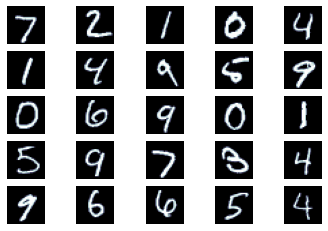

In [3]:
N_IMAGES = 25

images = [image for image, label in [test_data[i] for i in range(N_IMAGES)]]

plot_images(images)

# Sampling 2D images

In [171]:
def sample_image2D(images, num_sampling):
    sampled_data = []
    for Im,label in tqdm.tqdm(images):
        im = Im[0]
        shape = im.shape
        im = im - im.min()
        im = im / im.sum()
        weights = torch.tensor(im.flatten(), dtype=torch.float) # create a tensor of weights
        samples = torch.multinomial(weights, num_sampling, replacement=True)
        samples_y, samples_x = np.unravel_index(samples, shape)
        X = np.array([samples_x,samples_y],np.float32)
        X = torch.tensor(X)
        X = X - X.mean()
        X = X / X.std()
        sampled_data.append((X,label,Im[0]))
    return sampled_data

SAMPLING= 500

train_sampled = sample_image2D(images=train_data, num_sampling=SAMPLING)
test_sampled = sample_image2D(images=test_data, num_sampling=SAMPLING)

  0%|                                                                                                                                                                                                 | 0/60000 [00:00<?, ?it/s]/tmp/ipykernel_2853753/1565711914.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weights = torch.tensor(im.flatten(), dtype=torch.float) # create a tensor of weights
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 4346.00it/s]


# Random Encoder

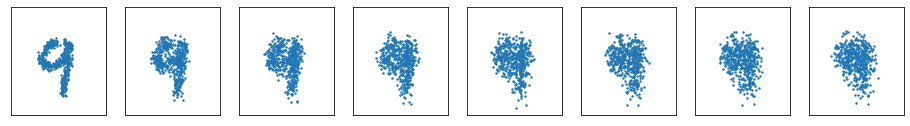

In [173]:

class MyMLP(nn.Module):
    def __init__(self, D, L, res):
        super().__init__()
        self.activ = F.relu
        self.fcs = [nn.Linear(D, D) for l in range(L)]
        for fc in self.fcs:
            # nn.init.xavier_normal_(w.weight,gain=1/np.sqrt(D))
            weights = torch.normal(0, 1.0/np.sqrt(D), size=fc.weight.shape)
            fc.weight.data = weights
        self.bns = [nn.BatchNorm1d(D) for l in range(L)]
        
        for li,(bn,fc) in enumerate(zip(self.bns,self.fcs)):
            self.add_module("fc_"+str(li), fc)
            self.add_module("bn_"+str(li), bn)
        self.L = L
        self.D = D
        self.res = res
        
    def layer_update(self, l,h):
        h2 = h
        h2 = self.activ(h2)
        h2 = self.fcs[l](h2)
        if l<len(self.fcs)-1:
            h2 = self.res * h + (1-self.res)*h2
        else:
            h2 = h
        h2 = my_layer_norm(h2)

        return h2


    def full_forward(self, h):
        shape = h.shape
        h = h.view(-1,h.shape[-1])
        h = my_layer_norm(h)
        H = [h.cpu().data.numpy()]
        for l in range(self.L):
            h = self.layer_update(l,h)
            H.append(h.view(shape).cpu().data.numpy())
        return H
    
    def forward(self, h):
        shape = h.shape
        h = h.view(-1,h.shape[-1])
        h = my_layer_norm(h)
        for l in range(self.L):
            h = self.layer_update(l,h)
        return h.view(shape)

    
def my_layer_norm(h):
    h = h - h.mean(-1,True)
    h = h / h.std(-1,keepdim=True)
    # h = h - h.mean()
    # h = h / h.std()
    return h


def show_layers(Hidden, Num=8,subplot=True,title=False,save_path=None):
    inds = np.linspace(1,len(Hidden)-1,num=Num,dtype=np.int32)
    Hidden = [Hidden[i] for i in inds]
    if subplot:
        fig = plt.figure(figsize=(2*Num,2))
    for Hi,(l,H) in enumerate(zip(inds,Hidden)):
        while H.shape[0]==1:
            H = H[0]
        # H = H.data.numpy()
        if subplot:
            ax = fig.add_subplot(1,8,Hi+1)
        else:
            plt.clf()
            ax = plt.gca()
        
        ax.scatter(H[0],-H[1],2)
        if title:
            ax.set_title(f'Layer = {Hi+1}')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlim(-5,5)
        ax.set_ylim(-4,4)
        if save_path:
            plt.savefig(f'{save_path}/{Hi}.png')
            


ENC_WIDTH = SAMPLING
ENC_LAYERS = 100
ENC_RES = .90

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

randNet = MyMLP(L=ENC_LAYERS,D=ENC_WIDTH,res=ENC_RES)
randNet = randNet.to(device)

r = np.random.randint(len(train_sampled))
X, y,im = train_sampled[r]
X = torch.unsqueeze(X,0).to(device)
Hidden = randNet.full_forward(X)
show_layers(Hidden)

In [174]:
def get_encodings(iterator, model):
    batches = []
    for (x, y, im) in tqdm.tqdm(iterator, leave=False):
            x = x.to(device)
            y = y.to(device)
            z = model(x)
            x,y,z = x.cpu(),y.cpu(),z.cpu()
            
            batches.append((x.data,y.data,z.data,im.data))
    encodings = [(x,y,z) for batch in batches for (x,y,z,im) in zip(*batch)]
    return encodings


ENC_BATCH_SIZE = 256

train_iterator = data.DataLoader(train_sampled,batch_size=ENC_BATCH_SIZE)
test_iterator = data.DataLoader(test_sampled,batch_size=ENC_BATCH_SIZE)
            
train_encodes = get_encodings(iterator=train_iterator,model=randNet)
test_encodes = get_encodings(iterator=test_iterator,model=randNet)

## Decoder Net

In [184]:
class MyMLP2(nn.Module):
    def __init__(self, D, A, L, res):
        super().__init__()
        self.activ = torch.nn.functional.relu
        self.att = nn.Linear(D ,A)
        self.att2 = nn.Linear(A, A) 
        self.att3 = nn.Linear(A ,A)
        self.att4 = nn.Linear(A, D) 
        self.sm0 = nn.Softmax(-1)
        self.sm = nn.functional.sigmoid
        # self.att3 = nn.Linear(A , D ) 
        
        self.A = A
        self.L = L
        self.D = D
        self.res = res


    def forward(self, h0):
        shape = h0.shape
        # h0 = h0.view(h0.shape[0],-1)
        h0 = h0.view(-1,h0.shape[-1])
        h = h0
        for l in range(self.L):
            h = self.att(h)
            h = self.sm(h)
            h = self.sm(h)
            # h = self.att2(h)
            # h = self.sm(h)
            # h = self.att3(h)
            # h = self.activ(h)
            h = self.att4(h)
            h = (self.res) * h0 + (1-self.res) * h #+ torch.normal(0,1e-1/self.D,size=h.shape).to(device)
            h = h - h.mean(-1,keepdim=True)
            h = h / h.std(-1,keepdim=True)
        return h.view(shape)
    

LAYERS = 1 # 100
ATT_LAYERS = 5000
RES = .0 # 1 - 1.0/LAYERS
EPOCHS = 1000
BATCH_SIZE = 512


INPUT_DIM = SAMPLING 
WIDTH = SAMPLING
OUTPUT_DIM = INPUT_DIM


train_iterator = data.DataLoader(train_encodes, shuffle=True, batch_size=BATCH_SIZE)
test_iterator = data.DataLoader(test_encodes, batch_size=BATCH_SIZE)

criterion = nn.MSELoss().to(device)
model = MyMLP2(WIDTH, ATT_LAYERS, LAYERS, RES).to(device)

In [185]:
model.parameters

<bound method Module.parameters of MyMLP2(
  (att): Linear(in_features=500, out_features=5000, bias=True)
  (att2): Linear(in_features=5000, out_features=5000, bias=True)
  (att3): Linear(in_features=5000, out_features=5000, bias=True)
  (att4): Linear(in_features=5000, out_features=500, bias=True)
)>

In [186]:
        
def sample_plot(Repeat=5, W=2, KDE=False):
    for param in model.parameters():
        param.requires_grad = False
    fig, axes = plt.subplots(3, Repeat,figsize=(Repeat*W,3*W))
    for ai in range(Repeat):
        X,_,Z = test_encodes[np.random.randint(len(test_encodes))]
        Z = Z.view(2,-1)
        X_pred = model(torch.unsqueeze(Z,0).to(device))
        X_pred = X_pred.view(2,-1).cpu().data
        X = X.cpu().data.numpy()
        for aj,A in enumerate([X,Z,X_pred]):
            ax = axes[aj][ai]
            if KDE:
                sns.kdeplot(ax=ax,x=A[0],y=-A[1],fill=True,bw_adjust=.5)
            else:
                ax.scatter(A[0],-A[1],1)
            ax.set_xlim(-4,4)
            ax.set_ylim(-3,3)
            ax.set_xticks([])
            ax.set_yticks([])

    for param in model.parameters():
        param.requires_grad = True
    fig.show()
    plt.savefig(f'fig{int(KDE)}.png')
    

best_valid_loss = float('inf')
optimizer = optim.Adam(model.parameters())
for epoch in range(EPOCHS):
    train_loss = recon_train(model, train_iterator, optimizer, criterion, device)
    valid_loss = recon_evaluate(model, test_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')

    print(f'Epoch: {epoch}\tTrain Loss: {train_loss:.5f}\t Val. Loss: {valid_loss:.5f}')
    # sample_plot(10,2)
    plt.show()

Epoch: 0	Train Loss: 0.78424	 Val. Loss: 0.14324


Epoch: 1	Train Loss: 0.16742	 Val. Loss: 0.13080


Epoch: 2	Train Loss: 0.16316	 Val. Loss: 0.12745


Epoch: 3	Train Loss: 0.16157	 Val. Loss: 0.12813


Epoch: 4	Train Loss: 0.15999	 Val. Loss: 0.12439


Epoch: 5	Train Loss: 0.15907	 Val. Loss: 0.12447


Epoch: 6	Train Loss: 0.15793	 Val. Loss: 0.12444


Epoch: 7	Train Loss: 0.15708	 Val. Loss: 0.12211


Epoch: 8	Train Loss: 0.15636	 Val. Loss: 0.12406


Epoch: 9	Train Loss: 0.15589	 Val. Loss: 0.12078


Epoch: 10	Train Loss: 0.15565	 Val. Loss: 0.12222


Epoch: 11	Train Loss: 0.15494	 Val. Loss: 0.12232


Epoch: 12	Train Loss: 0.15486	 Val. Loss: 0.12085


Epoch: 13	Train Loss: 0.15423	 Val. Loss: 0.12003


Epoch: 14	Train Loss: 0.15384	 Val. Loss: 0.12113


Epoch: 15	Train Loss: 0.15348	 Val. Loss: 0.12089


Epoch: 16	Train Loss: 0.15334	 Val. Loss: 0.12074


Epoch: 17	Train Loss: 0.15322	 Val. Loss: 0.12013


Epoch: 18	Train Loss: 0.15282	 Val. Loss: 0.12045


Epoch: 19	Train Loss: 0.15266	 Val. Loss: 0.12099


Epoch: 20	Train Loss: 0.15247	 Val. Loss: 0.11921


Epoch: 21	Train Loss: 0.15242	 Val. Loss: 0.11982


Epoch: 22	Train Loss: 0.15199	 Val. Loss: 0.12046


Epoch: 23	Train Loss: 0.15179	 Val. Loss: 0.12064


Epoch: 24	Train Loss: 0.15166	 Val. Loss: 0.12013


Epoch: 25	Train Loss: 0.15150	 Val. Loss: 0.12020


Epoch: 26	Train Loss: 0.15144	 Val. Loss: 0.12007


Epoch: 27	Train Loss: 0.15124	 Val. Loss: 0.11792


Epoch: 28	Train Loss: 0.15091	 Val. Loss: 0.11963


Epoch: 29	Train Loss: 0.15085	 Val. Loss: 0.11981


Epoch: 30	Train Loss: 0.15067	 Val. Loss: 0.11825


Epoch: 31	Train Loss: 0.15032	 Val. Loss: 0.11857


Epoch: 32	Train Loss: 0.15031	 Val. Loss: 0.11902


Epoch: 33	Train Loss: 0.15003	 Val. Loss: 0.11900


Epoch: 34	Train Loss: 0.15004	 Val. Loss: 0.11920


Epoch: 35	Train Loss: 0.14965	 Val. Loss: 0.11947


Epoch: 36	Train Loss: 0.14949	 Val. Loss: 0.11837


Epoch: 37	Train Loss: 0.14941	 Val. Loss: 0.11801


Epoch: 38	Train Loss: 0.14882	 Val. Loss: 0.11805


Epoch: 39	Train Loss: 0.14885	 Val. Loss: 0.11783


Epoch: 40	Train Loss: 0.14838	 Val. Loss: 0.11736


Epoch: 41	Train Loss: 0.14803	 Val. Loss: 0.11752


Epoch: 42	Train Loss: 0.14781	 Val. Loss: 0.11747


Epoch: 43	Train Loss: 0.14732	 Val. Loss: 0.11615


Epoch: 44	Train Loss: 0.14702	 Val. Loss: 0.11676


Epoch: 45	Train Loss: 0.14651	 Val. Loss: 0.11588


Epoch: 46	Train Loss: 0.14628	 Val. Loss: 0.11608


Epoch: 47	Train Loss: 0.14567	 Val. Loss: 0.11536


Epoch: 48	Train Loss: 0.14528	 Val. Loss: 0.11516


Epoch: 49	Train Loss: 0.14464	 Val. Loss: 0.11414


Epoch: 50	Train Loss: 0.14413	 Val. Loss: 0.11445


Epoch: 51	Train Loss: 0.14363	 Val. Loss: 0.11332


Epoch: 52	Train Loss: 0.14294	 Val. Loss: 0.11283


Epoch: 53	Train Loss: 0.14246	 Val. Loss: 0.11227


Epoch: 54	Train Loss: 0.14196	 Val. Loss: 0.11160


Epoch: 55	Train Loss: 0.14147	 Val. Loss: 0.11125


Epoch: 56	Train Loss: 0.14095	 Val. Loss: 0.11060


Epoch: 57	Train Loss: 0.14042	 Val. Loss: 0.10995


Epoch: 58	Train Loss: 0.13995	 Val. Loss: 0.10941


Epoch: 59	Train Loss: 0.13920	 Val. Loss: 0.10951


Epoch: 60	Train Loss: 0.13874	 Val. Loss: 0.10814


Epoch: 61	Train Loss: 0.13822	 Val. Loss: 0.10715


Epoch: 62	Train Loss: 0.13754	 Val. Loss: 0.10701


Epoch: 63	Train Loss: 0.13728	 Val. Loss: 0.10666


Epoch: 64	Train Loss: 0.13652	 Val. Loss: 0.10660


Epoch: 65	Train Loss: 0.13625	 Val. Loss: 0.10525


Epoch: 66	Train Loss: 0.13571	 Val. Loss: 0.10430


Epoch: 67	Train Loss: 0.13511	 Val. Loss: 0.10444


Epoch: 68	Train Loss: 0.13471	 Val. Loss: 0.10314


Epoch: 69	Train Loss: 0.13409	 Val. Loss: 0.10307


Epoch: 70	Train Loss: 0.13377	 Val. Loss: 0.10191


Epoch: 71	Train Loss: 0.13313	 Val. Loss: 0.10220


Epoch: 72	Train Loss: 0.13284	 Val. Loss: 0.10085


Epoch: 73	Train Loss: 0.13236	 Val. Loss: 0.10158


Epoch: 74	Train Loss: 0.13196	 Val. Loss: 0.10020


Epoch: 75	Train Loss: 0.13150	 Val. Loss: 0.09965


Epoch: 76	Train Loss: 0.13102	 Val. Loss: 0.09887


Epoch: 77	Train Loss: 0.13060	 Val. Loss: 0.09885


Epoch: 78	Train Loss: 0.13010	 Val. Loss: 0.09796


Epoch: 79	Train Loss: 0.12976	 Val. Loss: 0.09816


Epoch: 80	Train Loss: 0.12929	 Val. Loss: 0.09683


Epoch: 81	Train Loss: 0.12910	 Val. Loss: 0.09617


Epoch: 82	Train Loss: 0.12842	 Val. Loss: 0.09595


Epoch: 83	Train Loss: 0.12811	 Val. Loss: 0.09584


Epoch: 84	Train Loss: 0.12778	 Val. Loss: 0.09511


Epoch: 85	Train Loss: 0.12734	 Val. Loss: 0.09447


Epoch: 86	Train Loss: 0.12691	 Val. Loss: 0.09462


Epoch: 87	Train Loss: 0.12669	 Val. Loss: 0.09337


Epoch: 88	Train Loss: 0.12621	 Val. Loss: 0.09278


Epoch: 89	Train Loss: 0.12587	 Val. Loss: 0.09316


Epoch: 90	Train Loss: 0.12573	 Val. Loss: 0.09272


Epoch: 91	Train Loss: 0.12529	 Val. Loss: 0.09259


Epoch: 92	Train Loss: 0.12515	 Val. Loss: 0.09194


Epoch: 93	Train Loss: 0.12471	 Val. Loss: 0.09185


Epoch: 94	Train Loss: 0.12460	 Val. Loss: 0.09140


Epoch: 95	Train Loss: 0.12415	 Val. Loss: 0.09068


Epoch: 96	Train Loss: 0.12399	 Val. Loss: 0.09015


Epoch: 97	Train Loss: 0.12360	 Val. Loss: 0.08958


Epoch: 98	Train Loss: 0.12343	 Val. Loss: 0.08996


Epoch: 99	Train Loss: 0.12322	 Val. Loss: 0.08957


Epoch: 100	Train Loss: 0.12272	 Val. Loss: 0.08936


Epoch: 101	Train Loss: 0.12256	 Val. Loss: 0.08890


Epoch: 102	Train Loss: 0.12234	 Val. Loss: 0.08838


Epoch: 103	Train Loss: 0.12217	 Val. Loss: 0.08814


Epoch: 104	Train Loss: 0.12192	 Val. Loss: 0.08757


Epoch: 105	Train Loss: 0.12172	 Val. Loss: 0.08743


Epoch: 106	Train Loss: 0.12149	 Val. Loss: 0.08721


Epoch: 107	Train Loss: 0.12136	 Val. Loss: 0.08668


Epoch: 108	Train Loss: 0.12103	 Val. Loss: 0.08667


Epoch: 109	Train Loss: 0.12072	 Val. Loss: 0.08627


Epoch: 110	Train Loss: 0.12061	 Val. Loss: 0.08680


Epoch: 111	Train Loss: 0.12036	 Val. Loss: 0.08622


Epoch: 112	Train Loss: 0.12010	 Val. Loss: 0.08585


Epoch: 113	Train Loss: 0.12008	 Val. Loss: 0.08571


Epoch: 114	Train Loss: 0.11985	 Val. Loss: 0.08596


Epoch: 115	Train Loss: 0.11974	 Val. Loss: 0.08564


Epoch: 116	Train Loss: 0.11961	 Val. Loss: 0.08545


Epoch: 117	Train Loss: 0.11962	 Val. Loss: 0.08454


Epoch: 118	Train Loss: 0.11922	 Val. Loss: 0.08535


Epoch: 119	Train Loss: 0.11916	 Val. Loss: 0.08551


Epoch: 120	Train Loss: 0.11906	 Val. Loss: 0.08426


Epoch: 121	Train Loss: 0.11889	 Val. Loss: 0.08482


Epoch: 122	Train Loss: 0.11886	 Val. Loss: 0.08426


Epoch: 123	Train Loss: 0.11862	 Val. Loss: 0.08414


Epoch: 124	Train Loss: 0.11852	 Val. Loss: 0.08398


Epoch: 125	Train Loss: 0.11846	 Val. Loss: 0.08379


Epoch: 126	Train Loss: 0.11839	 Val. Loss: 0.08347


Epoch: 127	Train Loss: 0.11831	 Val. Loss: 0.08320


Epoch: 128	Train Loss: 0.11809	 Val. Loss: 0.08355


Epoch: 129	Train Loss: 0.11815	 Val. Loss: 0.08368


Epoch: 130	Train Loss: 0.11789	 Val. Loss: 0.08326


Epoch: 131	Train Loss: 0.11781	 Val. Loss: 0.08302


Epoch: 132	Train Loss: 0.11774	 Val. Loss: 0.08256


Epoch: 133	Train Loss: 0.11759	 Val. Loss: 0.08298


Epoch: 134	Train Loss: 0.11751	 Val. Loss: 0.08265


Epoch: 135	Train Loss: 0.11724	 Val. Loss: 0.08251


Epoch: 136	Train Loss: 0.11739	 Val. Loss: 0.08229


Epoch: 137	Train Loss: 0.11735	 Val. Loss: 0.08221


Epoch: 138	Train Loss: 0.11707	 Val. Loss: 0.08218


Epoch: 139	Train Loss: 0.11697	 Val. Loss: 0.08192


Epoch: 140	Train Loss: 0.11711	 Val. Loss: 0.08190


Epoch: 141	Train Loss: 0.11689	 Val. Loss: 0.08178


Epoch: 142	Train Loss: 0.11678	 Val. Loss: 0.08201


Epoch: 143	Train Loss: 0.11665	 Val. Loss: 0.08156


Epoch: 144	Train Loss: 0.11658	 Val. Loss: 0.08160


Epoch: 145	Train Loss: 0.11675	 Val. Loss: 0.08145


Epoch: 146	Train Loss: 0.11634	 Val. Loss: 0.08221


Epoch: 147	Train Loss: 0.11640	 Val. Loss: 0.08146


Epoch: 148	Train Loss: 0.11643	 Val. Loss: 0.08141


Epoch: 149	Train Loss: 0.11621	 Val. Loss: 0.08097


Epoch: 150	Train Loss: 0.11628	 Val. Loss: 0.08120


Epoch: 151	Train Loss: 0.11605	 Val. Loss: 0.08133


Epoch: 152	Train Loss: 0.11610	 Val. Loss: 0.08064


Epoch: 153	Train Loss: 0.11612	 Val. Loss: 0.08038


Epoch: 154	Train Loss: 0.11595	 Val. Loss: 0.08066


Epoch: 155	Train Loss: 0.11601	 Val. Loss: 0.08083


Epoch: 156	Train Loss: 0.11594	 Val. Loss: 0.08088


Epoch: 157	Train Loss: 0.11582	 Val. Loss: 0.08055


Epoch: 158	Train Loss: 0.11573	 Val. Loss: 0.08102


Epoch: 159	Train Loss: 0.11591	 Val. Loss: 0.08014


Epoch: 160	Train Loss: 0.11543	 Val. Loss: 0.08070


Epoch: 161	Train Loss: 0.11580	 Val. Loss: 0.08041


Epoch: 162	Train Loss: 0.11564	 Val. Loss: 0.08039


Epoch: 163	Train Loss: 0.11544	 Val. Loss: 0.08016


Epoch: 164	Train Loss: 0.11550	 Val. Loss: 0.08007


Epoch: 165	Train Loss: 0.11532	 Val. Loss: 0.08021


RuntimeError: [enforce fail at inline_container.cc:319] . unexpected pos 210061504 vs 210061424

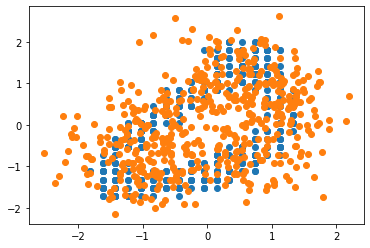

In [195]:
X,y,_ = test_encodes[np.random.randint(len(test_encodes))]
X_pred = model(torch.unsqueeze(X,0).to(device)).cpu().data[0]
plt.scatter(X[0],-X[1])
plt.scatter(X_pred[0],-X_pred[1])

# Decoding from noise

In [189]:
X,y,_ = test_encodes[np.random.randint(len(test_encodes))]

Hidden = randNet.full_forward(torch.unsqueeze(X,0).to(device))
Z = torch.tensor(Hidden[-1])
Hidden2 = model.full_forward(torch.unsqueeze(Z,0).to(device))

show_layers(Hidden, Num=8)
show_layers(Hidden2, Num=8)


AttributeError: 'MyMLP2' object has no attribute 'full_forward'